In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import SGD, Adam
from torch.distributions.multinomial import Multinomial
from torch.distributions.normal import Normal

# Data

In [2]:
N = 1000
x = np.random.uniform(-10, 10, N)
noise = np.random.normal(0, 1, N)
y = 3 * np.sin(x) + noise

In [3]:
x, y = y, x

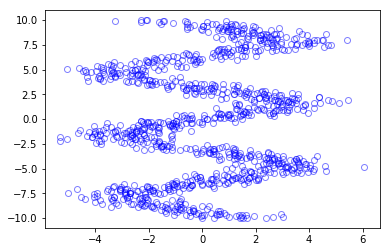

In [4]:
plt.plot(x, y, 'bo', alpha=0.5, markerfacecolor='none')

In [5]:
x_tensor = torch.tensor(x).unsqueeze(1).float()
y_tensor = torch.tensor(y).unsqueeze(1).float()

# Multilayer perceptron model

In [6]:
class MLP(nn.Module):
    def __init__(self, dim_hidden):
        super().__init__()
        self.hidden = nn.Linear(1, dim_hidden)
        self.output = nn.Linear(dim_hidden, 1)

    def forward(self, x):
        h = torch.tanh(self.hidden(x))
        o = self.output(h)
        return o

In [7]:
mlp = MLP(10)
mlp

MLP(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)

In [8]:
optimizer = SGD(mlp.parameters(), lr=0.1)

epochs = 10000

for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    out = mlp.forward(x_tensor)
    loss = F.mse_loss(out, y_tensor)
    if epoch == 1 or epoch % 2000 == 0 or epoch == epochs:
        print(f'epoch {epoch}, loss = {loss}')
    loss.backward()
    optimizer.step()

epoch 1, loss = 31.877281188964844
epoch 2000, loss = 31.298900604248047
epoch 4000, loss = 31.171709060668945
epoch 6000, loss = 31.081830978393555
epoch 8000, loss = 31.01070785522461
epoch 10000, loss = 30.97571563720703


In [9]:
x_test = np.linspace(-5, 5, N)
x_test_tensor = torch.tensor(x_test).unsqueeze(1).float()

In [10]:
y_test_tensor = mlp.forward(x_test_tensor)
y_test = y_test_tensor.squeeze(1).tolist()

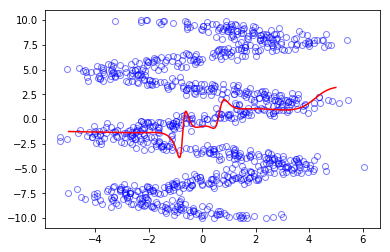

In [11]:
plt.plot(x, y, 'bo', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, y_test, 'r')

# Maximum density network model

In [12]:
class MDN(nn.Module):
    def __init__(self, dim_hidden, K):
        super().__init__()
        self.hidden = nn.Linear(1, dim_hidden)
        self.pi = nn.Linear(dim_hidden, K)
        self.mu = nn.Linear(dim_hidden, K)
        self.sigma = nn.Linear(dim_hidden, K)

    def forward(self, x):
        h = torch.tanh(self.hidden(x))
        pi = torch.softmax(self.pi(h), dim=-1)
        mu = self.mu(h)
        sigma = self.sigma(h).exp()
        return (pi, mu, sigma)

In [13]:
def likelihood_loss(pi, mu, sigma, y):
    n, K = pi.shape
    
    losses = torch.zeros(1, n)
    for k in range(K):
        gaussian = Normal(mu[:, k], sigma[:, k])
        prob = gaussian.log_prob(y.squeeze(1)).exp()
        losses += pi[:, k] * prob

    return -losses.log().mean()

In [14]:
mdn = MDN(100, K=7)
mdn

MDN(
  (hidden): Linear(in_features=1, out_features=100, bias=True)
  (pi): Linear(in_features=100, out_features=7, bias=True)
  (mu): Linear(in_features=100, out_features=7, bias=True)
  (sigma): Linear(in_features=100, out_features=7, bias=True)
)

In [15]:
optimizer = Adam(mdn.parameters(), lr=1e-3)

epochs = 30000

for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    pi, mu, sigma = mdn.forward(x_tensor)
    loss = likelihood_loss(pi, mu, sigma, y_tensor)
    if epoch == 1 or epoch % 2000 == 0 or epoch == epochs:
        print(f'epoch {epoch}, loss = {loss}')
    loss.backward()
    optimizer.step()

epoch 1, loss = 7.731873512268066
epoch 2000, loss = 2.4094908237457275
epoch 4000, loss = 2.282849073410034
epoch 6000, loss = 2.249066114425659
epoch 8000, loss = 2.249992847442627
epoch 10000, loss = 2.2331814765930176
epoch 12000, loss = 2.223294496536255
epoch 14000, loss = 2.2171425819396973
epoch 16000, loss = 2.2104125022888184
epoch 18000, loss = 2.202645778656006
epoch 20000, loss = 2.208540201187134
epoch 22000, loss = 2.1944031715393066
epoch 24000, loss = 2.1928670406341553
epoch 26000, loss = 2.1859774589538574
epoch 28000, loss = 2.1885111331939697
epoch 30000, loss = 2.18282151222229


In [16]:
def generate_mus(model, xs):
    """
    For each input x and each center c_k(x) of the k-th gaussian in the GMM, generate (x, c_k(x)).
    """
    pis, mus, _ = model.forward(xs)
    for i, x in enumerate(xs):
        for pi, mu in zip(pis[i], mus[i]):
            if pi > 1e-3:
                yield x.item(), mu.item()

In [17]:
x_test = np.linspace(-5, 5, N)
x_test_tensor = torch.tensor(x_test).unsqueeze(1).float()

In [18]:
preds = list(generate_mus(mdn, x_test_tensor))
x_pred, y_pred = zip(*preds)

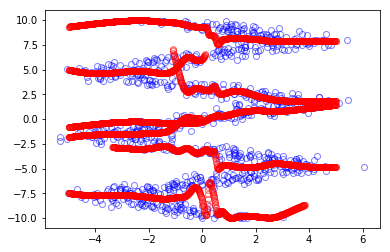

In [19]:
plt.plot(x, y, 'bo', alpha=0.5, markerfacecolor='none')
plt.plot(x_pred, y_pred, 'ro', alpha=0.5, markerfacecolor='none')

In [25]:
def sample(model, xs, n=1):
    """
    For each input x, sample n points y_i(x) (i in [1..n]) from the GMM and yield (x, y_i(x)).
    """
    pis, mus, sigmas = model.forward(xs)
    for i, x in enumerate(xs):
        for k in torch.multinomial(pis[i], n):
            gaussian = Normal(mus[i, k], sigmas[i, k])
            yield x.item(), gaussian.sample().item()

In [26]:
preds = list(sample(mdn, x_test_tensor, n=3))
x_pred, y_pred = zip(*preds)

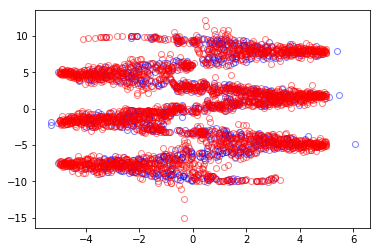

In [27]:
plt.plot(x, y, 'bo', alpha=0.5, markerfacecolor='none')
plt.plot(x_pred, y_pred, 'ro', alpha=0.5, markerfacecolor='none')